In [1]:
from typing import List, Iterator
from collections import defaultdict

from tqdm import tqdm
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, Sampler

from Config import config
from utils import utils, dataset_utils

In [2]:
class BatchBySizeSampler(Sampler[List[int]]):
    def __init__(self, data, batch_size: int, randomize=True):
        self.batch_size = batch_size
        self.randomize = randomize
        self.paths_by_length = defaultdict(list)
        for i in range(len(data)):
            self.paths_by_length[len(data[i])].append(i)
        self.num_batches = sum((len(xs) + batch_size - 1) // batch_size for xs in self.paths_by_length.values())

    def __len__(self):
        return self.num_batches

    def __iter__(self) -> Iterator[List[int]]:
        if self.randomize:
            for xs in self.paths_by_length.values():
                np.random.shuffle(xs)
        chunks = [xs[i : i + self.batch_size] for xs in self.paths_by_length.values() for i in range(0, len(xs), self.batch_size)]
        for batch in chunks:
            yield batch

trainset = dataset_utils.AISDataset('data/Unlabelled Data/datasetInfo_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_600_43200_120.pkl', combined=True)
testset = dataset_utils.AISDataset('data/Labelled Data/datasetInfo_AIS_Custom_13122021_13122021_CarFisHigMilPasPleSaiTan_600_43200_120.pkl', combined=True, train_preproc = (trainset.mean, trainset.std))

print(len(trainset))
print(len(testset))

batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_sampler=BatchBySizeSampler(trainset, batch_size))
test_loader = torch.utils.data.DataLoader(testset, batch_sampler=BatchBySizeSampler(testset, batch_size, randomize=False))

3000
521


In [3]:
LSTM_HIDDEN_DIM = 64
BIDI_LSTM = True
DROPOUT = 0.0

class LSTMWrapper(nn.Module):
    def __init__(self, num_features, hidden_dim, batch_first, bidirectional):
        super().__init__()
        self.lstm = nn.LSTM(num_features, hidden_dim, batch_first=batch_first, bidirectional=bidirectional)

    def forward(self, X):
        res, _ = self.lstm(X)
        return res[:, -1]

class AutoEncoder(nn.Module):
    def __init__(self, num_features, max_output_length):
        super().__init__()

        self.encoder = nn.Sequential(
            LSTMWrapper(num_features, LSTM_HIDDEN_DIM, batch_first=True, bidirectional=BIDI_LSTM),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(LSTM_HIDDEN_DIM * (1 + BIDI_LSTM), 64),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(128, num_features * max_output_length),
            nn.Unflatten(-1, (max_output_length, num_features))
        )

    def forward(self, X):
        res = self.encoder(X)
        res = self.decoder(res)
        return res[:, : X.shape[-2]]

max_output_length = torch.max(torch.cat([trainset.lengths, testset.lengths])).item()
model = AutoEncoder(2, max_output_length)

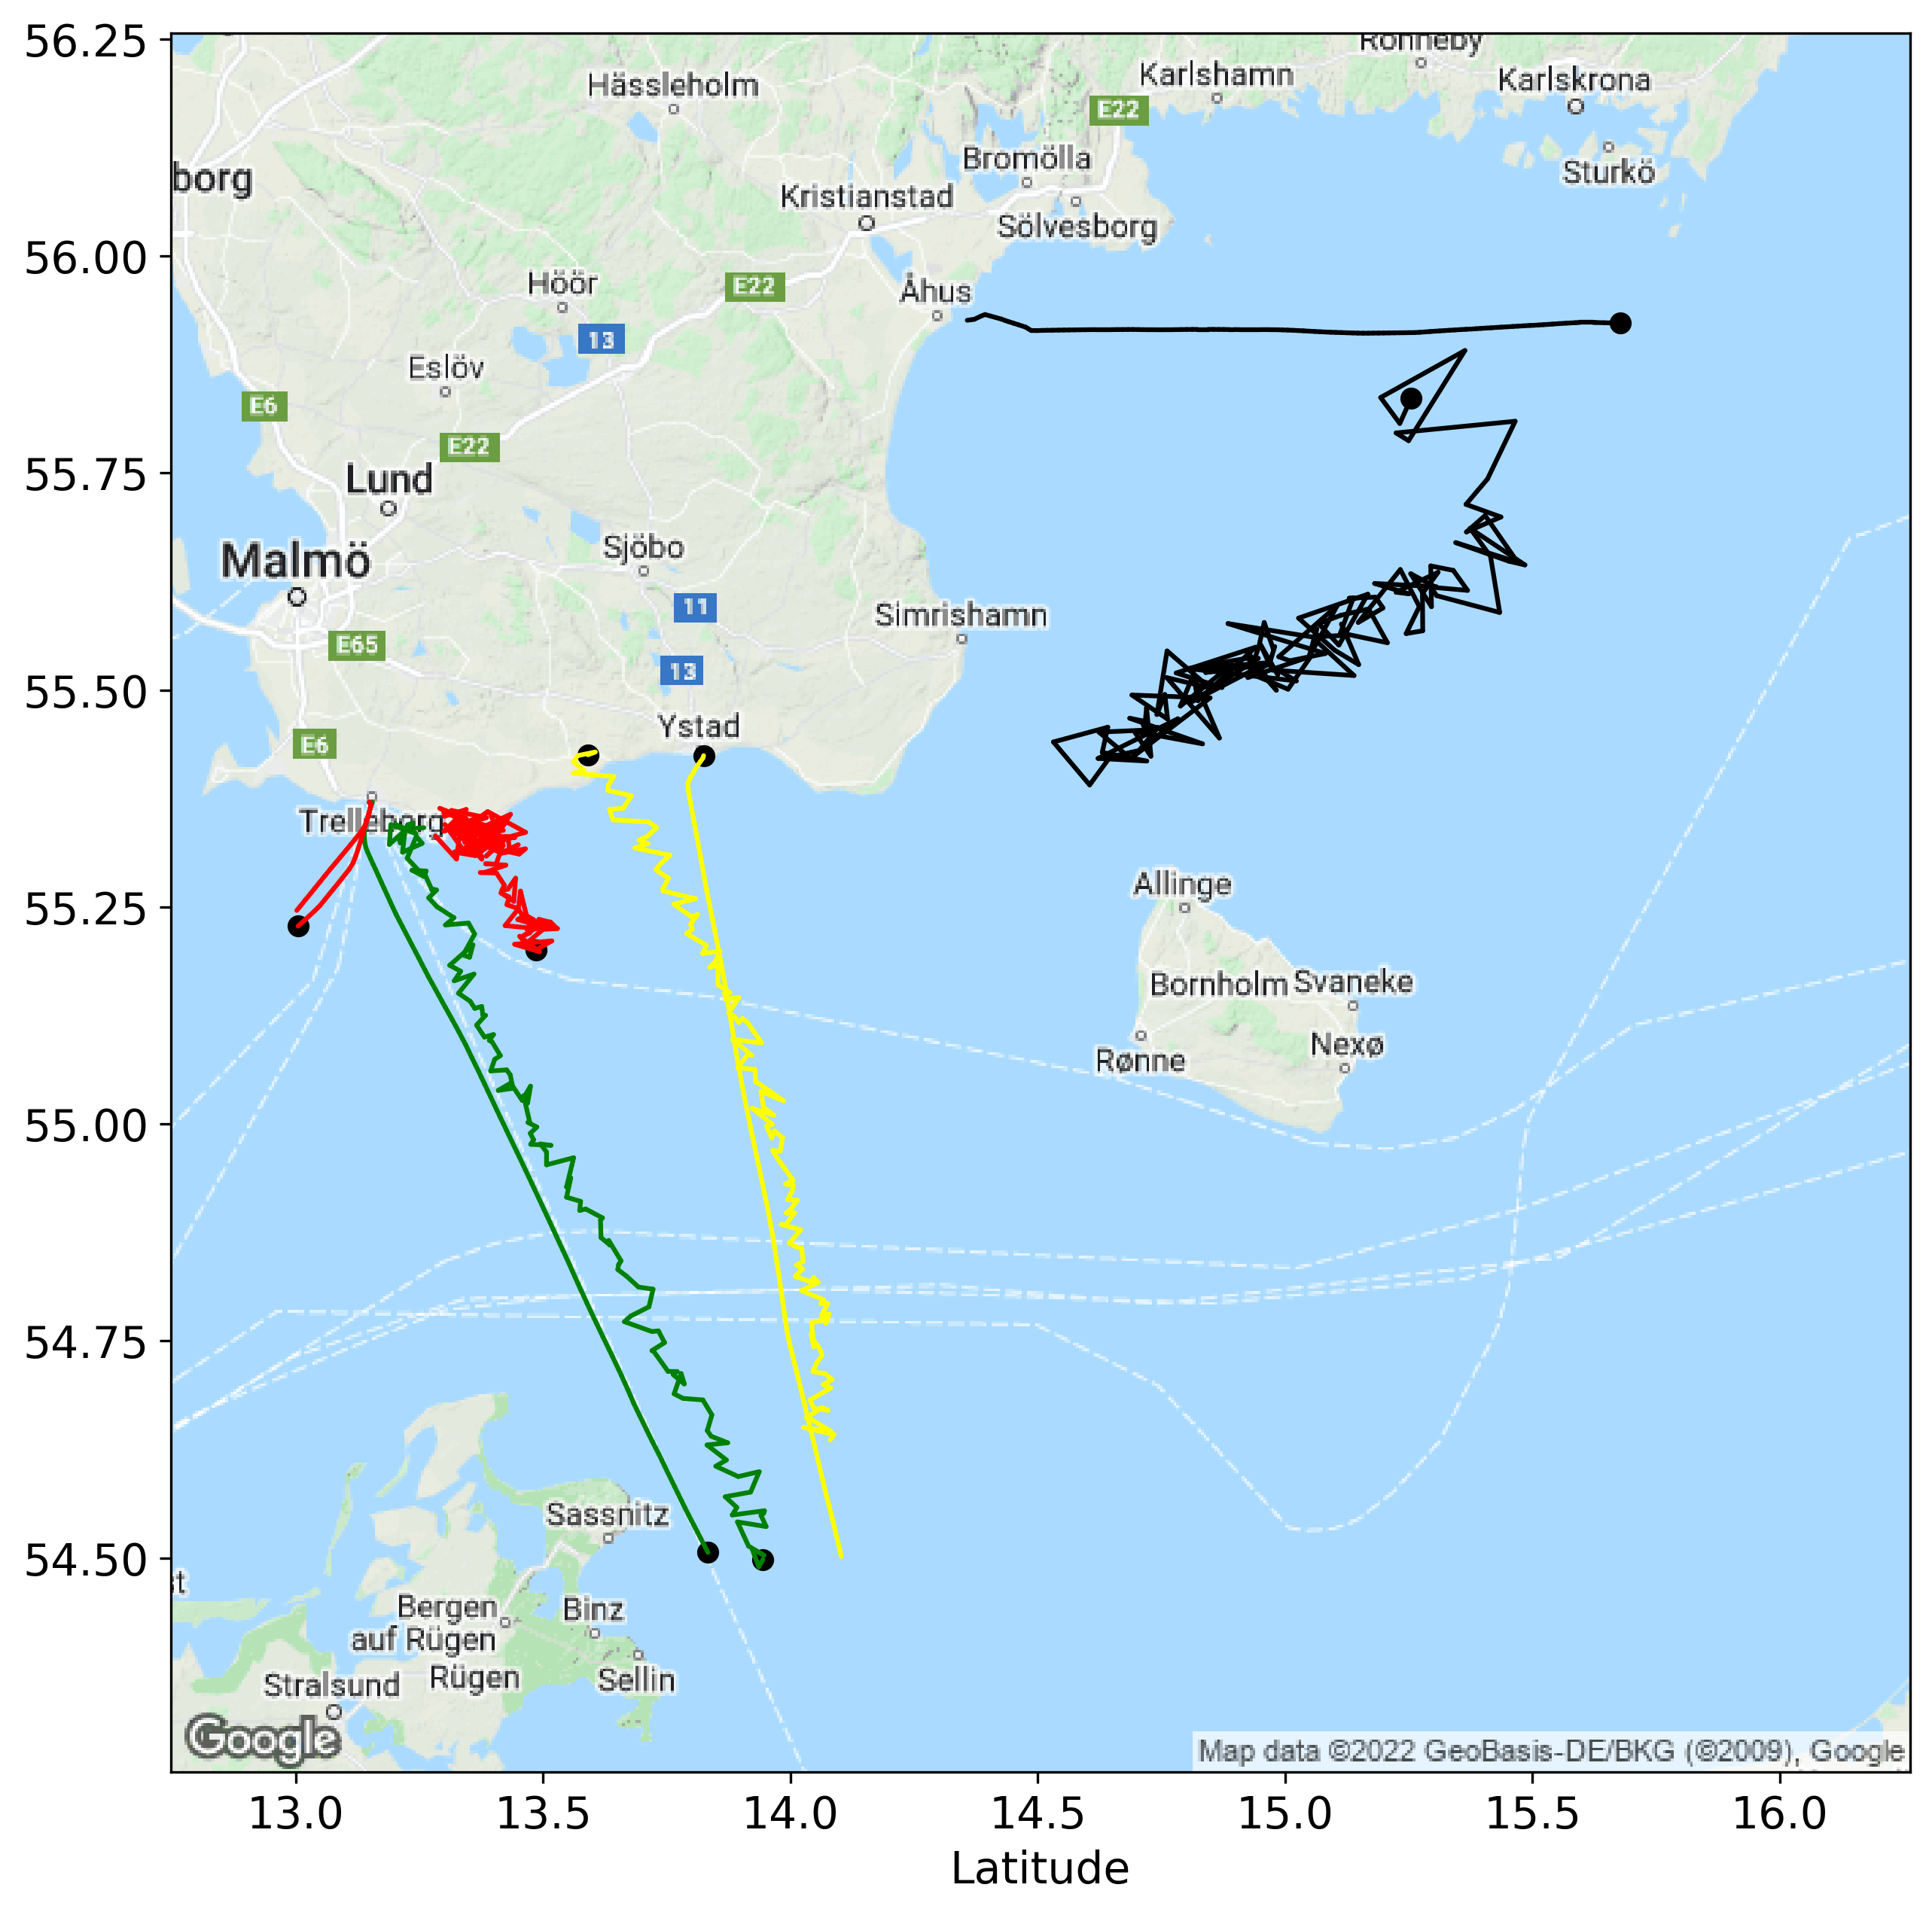

In [14]:
LOAD_MODEL = True

if LOAD_MODEL:
    model = torch.load("model.pt")

    colors = [
        "Green",
        "Red",
        "Yellow",
        "Black",
        "Pink",
        "Purple",
        "Orange",
        "mediumblue",
        "aquamarine"
    ]

    filename = './data/Labelled Data/datasetInfo_AIS_Custom_13122021_13122021_CarFisHigMilPasPleSaiTan_600_43200_120.pkl'

    data, params, mmsis, shiptypes, lengths = dataset_utils.readDataset(filename)

    with torch.no_grad():
        X = next(iter(test_loader))[:5]
        X_pred = model(X)

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    utils.plotMapBackground(ax, params['binedges'], c=0)
    found = False
    with torch.no_grad():
        for i, X in enumerate(test_loader):
            # if not found and X.shape[1] > 330:
            if i in [0]:
                found = True
                X_pred = model(X)
                for j, (x, x_pred) in enumerate(zip(X, X_pred)):
                    if j < len(colors):
                        utils.plotTrack(testset.reconstruct(x), None, ax, color=colors[j], lsty='solid', insertSpeed=False, label="True path")
                        utils.plotTrack(testset.reconstruct(x_pred), None, ax, color=colors[j], lsty='solid', insertSpeed=False, label="Predicted path")

In [5]:
NUM_EPOCHS = 30

loss_fn = nn.L1Loss()
optimizer = torch.optim.NAdam(model.parameters(), lr=2e-4)

for epoch in range(NUM_EPOCHS):
    losses = []
    for X in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        y_pred = model(X)
        loss = loss_fn(X, y_pred)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Avg loss = {np.mean(losses)}")

model.eval()

Epoch 1: 100%|██████████| 355/355 [00:07<00:00, 45.05it/s]


Avg loss = 0.9121337596799286


Epoch 2: 100%|██████████| 355/355 [00:08<00:00, 41.03it/s]


Avg loss = 0.7635277335912409


Epoch 3: 100%|██████████| 355/355 [00:08<00:00, 40.52it/s]


Avg loss = 0.7352022278476769


Epoch 4: 100%|██████████| 355/355 [00:08<00:00, 42.48it/s]


Avg loss = 0.6701861182568778


Epoch 5: 100%|██████████| 355/355 [00:08<00:00, 41.21it/s]


Avg loss = 0.6178661591989894


Epoch 6: 100%|██████████| 355/355 [00:08<00:00, 41.60it/s]


Avg loss = 0.5910234911760813


Epoch 7: 100%|██████████| 355/355 [00:08<00:00, 42.51it/s]


Avg loss = 0.5612229762782514


Epoch 8: 100%|██████████| 355/355 [00:08<00:00, 41.51it/s]


Avg loss = 0.5517896929677104


Epoch 9: 100%|██████████| 355/355 [00:08<00:00, 41.81it/s]


Avg loss = 0.5312451112858007


Epoch 10: 100%|██████████| 355/355 [00:09<00:00, 37.43it/s]


Avg loss = 0.5095009799994213


Epoch 11: 100%|██████████| 355/355 [00:12<00:00, 28.40it/s]


Avg loss = 0.4870751100106978


Epoch 12: 100%|██████████| 355/355 [00:12<00:00, 28.76it/s]


Avg loss = 0.45801494591672653


Epoch 13: 100%|██████████| 355/355 [00:12<00:00, 28.92it/s]


Avg loss = 0.44479452480732556


Epoch 14: 100%|██████████| 355/355 [00:12<00:00, 27.59it/s]


Avg loss = 0.445005120357997


Epoch 15: 100%|██████████| 355/355 [00:12<00:00, 28.88it/s]


Avg loss = 0.425887388809466


Epoch 16: 100%|██████████| 355/355 [00:12<00:00, 29.19it/s]


Avg loss = 0.4398409759914371


Epoch 17: 100%|██████████| 355/355 [00:12<00:00, 28.00it/s]


Avg loss = 0.3925695472200152


Epoch 18: 100%|██████████| 355/355 [00:12<00:00, 29.55it/s]


Avg loss = 0.37549438303415206


Epoch 19: 100%|██████████| 355/355 [00:15<00:00, 22.84it/s]


Avg loss = 0.36129650130448204


Epoch 20: 100%|██████████| 355/355 [00:15<00:00, 23.22it/s]


Avg loss = 0.36887732202738105


Epoch 21: 100%|██████████| 355/355 [00:12<00:00, 29.31it/s]


Avg loss = 0.3427520981347057


Epoch 22: 100%|██████████| 355/355 [00:12<00:00, 29.38it/s]


Avg loss = 0.35032602018663583


Epoch 23: 100%|██████████| 355/355 [00:11<00:00, 30.42it/s]


Avg loss = 0.3426179010158693


Epoch 24: 100%|██████████| 355/355 [00:14<00:00, 24.40it/s]


Avg loss = 0.3806376441893443


Epoch 25: 100%|██████████| 355/355 [00:12<00:00, 28.08it/s]


Avg loss = 0.3502504395871935


Epoch 26: 100%|██████████| 355/355 [00:10<00:00, 33.60it/s]


Avg loss = 0.3311291960553384


Epoch 27: 100%|██████████| 355/355 [00:12<00:00, 28.64it/s]


Avg loss = 0.3129219500951364


Epoch 28: 100%|██████████| 355/355 [00:12<00:00, 28.40it/s]


Avg loss = 0.2904192220262239


Epoch 29: 100%|██████████| 355/355 [00:11<00:00, 30.29it/s]


Avg loss = 0.2748788808538041


Epoch 30: 100%|██████████| 355/355 [00:12<00:00, 28.83it/s]

Avg loss = 0.266472291295797


AutoEncoder(
  (encoder): Sequential(
    (0): LSTMWrapper(
      (lstm): LSTM(2, 64, batch_first=True, bidirectional=True)
    )
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=720, bias=True)
    (4): Unflatten(dim=-1, unflattened_size=(360, 2))
  )
)

In [6]:
if True:
    torch.save(model, "model.pt")

In [7]:
with torch.no_grad():
    loss_fn = nn.L1Loss()
    
    reconstruct = True
    if reconstruct:
        mean_train_loss = np.mean([loss_fn(trainset.reconstruct(model(X)), trainset.reconstruct(X)).item() for X in train_loader])
        mean_test_loss = np.mean([loss_fn(testset.reconstruct(model(X)), testset.reconstruct(X)).item() for X in test_loader])
    else:
        mean_train_loss = np.mean([loss_fn(model(X), X).item() for X in train_loader])
        mean_test_loss = np.mean([loss_fn(model(X), X).item() for X in test_loader])

    print(mean_train_loss, mean_test_loss)

0.16575319438543118 0.2105045745318586


In [13]:
with torch.no_grad():
    for X in test_loader:
        print("Original:   ", [[(f"{x:.4f}") for x in xs] for xs in testset.reconstruct(X[0,:5]).tolist()])
        print("Autoencoded:", [[f"{x:.4f}" for x in xs] for xs in testset.reconstruct(model(X)[0,:5]).tolist()])
        break

Original:    [['54.5064', '13.8333'], ['54.5143', '13.8261'], ['54.5223', '13.8190'], ['54.5302', '13.8118'], ['54.5382', '13.8046']]
Autoencoded: [['54.4982', '13.9445'], ['54.4896', '13.9362'], ['54.5104', '13.9227'], ['54.5029', '13.9466'], ['54.5137', '13.9154']]
